In [ ]:
import numpy as np
from definitions import *

In [ ]:
model_name = 'predator_prey'

args = {
    'model_name': model_name,
    'experiment_name': '{}_recovery_with_nans'.format(model_name),
    'need_retrain': False,
    'learning_rate': 1e-1,
    'epochs_before_decay': 0.1,
    'epochs_count': 30,
    'learning_rate_decay': 1/3,
    'iterations_count': 300,
}

In [ ]:
import tensorflow as tf

general_params = \
    {
        'phi_h': tf.keras.activations.linear,
        'phi_o': tf.keras.activations.linear,
    }

train_params = \
    {
        'learning_rate': args['learning_rate'],
        'epochs_before_decay': args['epochs_before_decay'],
        'epochs_count': args['epochs_count'],
        'learning_rate_decay': args['learning_rate_decay'],
        'early_stopping_patience': 10,
    }


In [ ]:
KNOWN_MODEL = 'known model'
UNKNOWN_MODEL = 'unknown model'

In [ ]:
model_name = args['model_name']
need_train = bool(args['need_retrain'])
mode = UNKNOWN_MODEL

dataset_file_name = '{}_dataset.csv'.format(model_name)
dataset_dir = path_join(DATA_DIR, model_name)
dataset_path = path_join(dataset_dir, dataset_file_name)

experiment_name = args['experiment_name']
experiment_dir = path_join(EXPERIMENTS_DIR, experiment_name)
make_directory(experiment_dir)

tf_model_dir = path_join(experiment_dir, 'tf_model')
make_directory(tf_model_dir)

images_dir = path_join(experiment_dir, 'images')
make_directory(images_dir)

log_path = path_join(experiment_dir, 'log.log')
logging.basicConfig(filename=log_path, level=logging.INFO)

vensim_model_file = path_join(VENSIM_MODELS_DIR, '{}.mdl'.format(model_name))

prn_model_dir = path_join(tf_model_dir, 'prn_model')
nn_model_dir = path_join(tf_model_dir, 'nn_model')
make_directory(prn_model_dir)
make_directory(nn_model_dir)

In [ ]:
from definitions import path_join, DATA_DIR

dataset_dir = path_join(DATA_DIR, model_name)
dataset_file = path_join(dataset_dir, 'dataset_2000.csv')

In [ ]:
import pandas as pd

data = pd.read_csv(dataset_file)
dt = 0.03125
stopwords = ['TIME', 'sim_index']
fields = [column for column in data.columns if column not in stopwords]

In [ ]:
from module.fd_model.vensim_fd_converter import create_unknown_model

FD = create_unknown_model(fields)
FD.dT = dt

print('dt: {}'.format(dt))

In [ ]:
from sklearn.model_selection import train_test_split


def np_preproc_for_rnn3d(numpy_array, fields):
    x_groups = [group[1][fields].values[:-1] for group in numpy_array]
    y_groups = [group[1][fields].values[1:] for group in numpy_array]
    
    train_X, valid_X, train_y, valid_y = train_test_split(x_groups, y_groups, test_size=0.2, random_state=123)
    
    train_X = np.concatenate(train_X, axis=0)
    valid_X = np.concatenate(valid_X, axis=0)
    
    train_y = np.concatenate(train_y, axis=0)
    valid_y = np.concatenate(valid_y, axis=0)

    return (train_X, train_y), (valid_X, valid_y)


def generate_train_data(df, fields):
    dataset = df[fields].values
    grouped = df.groupby(['sim_index'])[fields]
    
    return dataset, np_preproc_for_rnn3d(grouped, fields)

In [10]:
_, (prn_train, prn_valid) = generate_train_data(data, fields)

In [11]:
prn_train_X, prn_train_y = prn_train
prn_valid_X, prn_valid_y = prn_valid

In [12]:
nans_percents = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [14]:
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from module.fd_model.fd_rnn_converter import FDRNNConverter
from module.nn_model_tf_v2 import NNModel as NNModelv2
import pickle
choosed_model = NNModelv2

for nans_percent in nans_percents:
    test_percent = 0.2
    X_train, X_test, y_train, y_test = train_test_split(prn_train_X, prn_train_y, test_size=test_percent, random_state=123)

    c = int(X_train.shape[0] * (nans_percent / 100))
    X_train.ravel()[np.random.choice(X_train.size, c, replace=False)] = 0.1
    
    ops.reset_default_graph()

    FDRNN_converter = FDRNNConverter(general_params['phi_h'], general_params['phi_o'])
    rnn_model = FDRNN_converter.fd_to_rnn(FD, choosed_model)
    new_prn_model_dir = prn_model_dir + '_{}_nans_percent'.format(nans_percent)
    
    if nans_percent > 4:
        if need_train:
            rnn_model.train(X_train, y_train, (X_test, y_test), train_params, new_prn_model_dir)

        rnn_model.load(new_prn_model_dir)
        initial_value = np.reshape(X_test[0], [1, X_test.shape[1]])
        prn_iterative = rnn_model.get_simulation(initial_value, args['iterations_count'], new_prn_model_dir)
        import pickle
        with open(new_prn_model_dir + '/preds.pickle', 'wb') as file:
            pickle.dump(prn_iterative, file)
        print('{}% nans preds saved'.format(nans_percent))

        with open(new_prn_model_dir + '/y_test.pickle', 'wb') as file:
            pickle.dump(y_test, file)

Train on 384000 samples, validate on 96000 samples
Epoch 1/30
384000/384000 [==============================] - 28s 73us/sample - loss: 166.2395 - mse: 166.2395 - val_loss: 8.6902 - val_mse: 8.6902
Epoch 2/30
384000/384000 [==============================] - 29s 75us/sample - loss: 153.8306 - mse: 153.8306 - val_loss: 4.5844 - val_mse: 4.5844
Epoch 3/30
384000/384000 [==============================] - 26s 69us/sample - loss: 153.0493 - mse: 153.0493 - val_loss: 3.6023 - val_mse: 3.6023
Epoch 4/30
384000/384000 [==============================] - 26s 68us/sample - loss: 153.2287 - mse: 153.2286 - val_loss: 1.8187 - val_mse: 1.8187
Epoch 5/30
384000/384000 [==============================] - 26s 68us/sample - loss: 153.7125 - mse: 153.7124 - val_loss: 3.6096 - val_mse: 3.6096
Epoch 6/30
384000/384000 [==============================] - 27s 71us/sample - loss: 154.6629 - mse: 154.6631 - val_loss: 3.1051 - val_mse: 3.1051
Epoch 7/30
384000/384000 [==============================] - 26s 68us/samp

In [13]:
import pickle

def load_loss_data(nans_percents):
    data = {}
    for nans_percent in nans_percents:
        new_prn_model_dir = prn_model_dir + '_{}_nans_percent'.format(nans_percent)
        file_name = path_join(new_prn_model_dir, 'loss_history')
        print(file_name)
        with open(file_name, 'rb') as file:
            prn_train_data = pickle.load(file)
        data[nans_percent] = prn_train_data
    
    return data

In [14]:
loss_data = load_loss_data(nans_percents)

C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_0_nans_percent\loss_history
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_1_nans_percent\loss_history
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_2_nans_percent\loss_history
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_3_nans_percent\loss_history
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_4_nans_percent\loss_history
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_5_nans_percent\loss_history
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_6_nans_percent\loss_history
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans

In [15]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

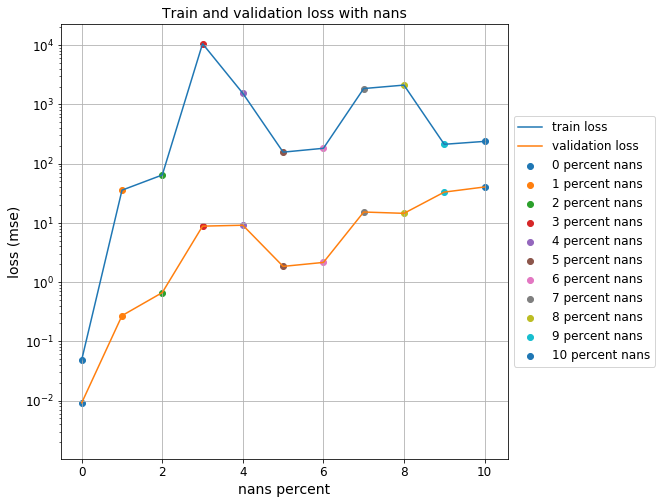

In [38]:
import matplotlib.pyplot as plt
import pickle
import os

plt.figure(figsize=(8, 8))
means = []
means2 = []
for nans_percent in loss_data.keys():
    loss_data_part = loss_data[nans_percent]
    _mean = np.mean(loss_data_part['loss'][-3:])
    _mean2 = np.mean(loss_data_part['val_loss'][-3:])
    means.append(_mean)
    means2.append(_mean2)
#     plt.plot(loss_data_part['loss'], label='{} percent nans'.format(nans_percent))
    plt.scatter([nans_percent, nans_percent],  [_mean, _mean2], label='{} percent nans'.format(nans_percent))

plt.plot(nans_percents,  means, label='train loss'.format(nans_percent))
plt.plot(nans_percents,  means2, label='validation loss'.format(nans_percent))
plt.xlabel('nans percent')
plt.ylabel('loss (mse)')

# plt.xlim(0)
y_ticks = [10 ** i for i in range(-10, 5)]

title = 'Train and validation loss with nans'
plt.title(title)

plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig(os.path.join(images_dir, title))

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


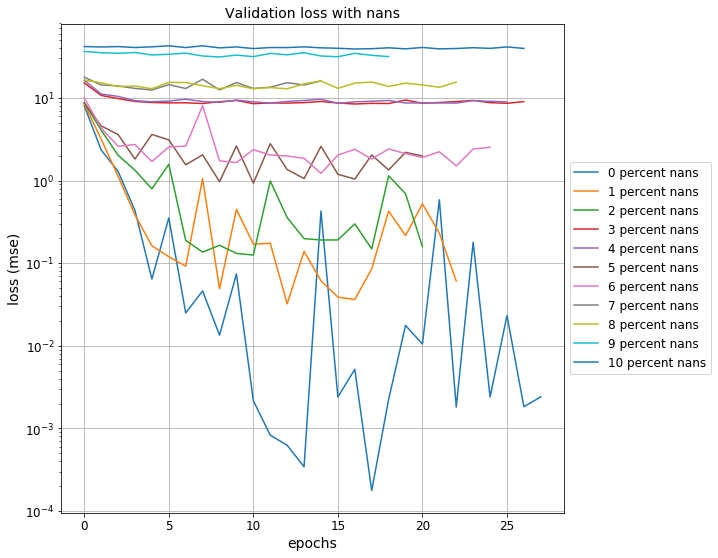

In [37]:
plt.figure(figsize=(9, 9))
for nans_percent in loss_data.keys():
    loss_data_part = loss_data[nans_percent]
    plt.plot(loss_data_part['val_loss'], label='{} percent nans'.format(nans_percent))

plt.xlabel('epochs')
plt.ylabel('loss (mse)')

y_ticks = [10 ** i for i in range(-10, 5)]
print(y_ticks)

title = 'Validation loss with nans'
plt.title(title)

plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig(os.path.join(images_dir, title))

In [13]:
import pickle

def load_preds_data(nans_percents):
    data = {}
    for nans_percent in nans_percents:
        new_prn_model_dir = prn_model_dir + '_{}_nans_percent'.format(nans_percent)
        file_name = path_join(new_prn_model_dir, 'preds.pickle')
        print(file_name)
        with open(file_name, 'rb') as file:
            prn_preds_data = pickle.load(file)
        data[nans_percent] = prn_preds_data
    
    return data

In [14]:
preds_data = load_preds_data(nans_percents)

C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_0_nans_percent\preds.pickle
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_1_nans_percent\preds.pickle
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_2_nans_percent\preds.pickle
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_3_nans_percent\preds.pickle
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_4_nans_percent\preds.pickle
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_5_nans_percent\preds.pickle
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_6_nans_percent\preds.pickle
C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans

In [15]:
new_prn_model_dir = prn_model_dir + '_{}_nans_percent'.format(nans_percents[0])
y_test_file_name = path_join(new_prn_model_dir, 'y_test.pickle')
print(y_test_file_name)
with open(y_test_file_name, 'rb') as file:
    y_test = pickle.load(file)

C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_recovery_with_nans\tf_model\prn_model_0_nans_percent\y_test.pickle


In [16]:
y_test.shape

(96000, 6)

<Figure size 432x288 with 0 Axes>

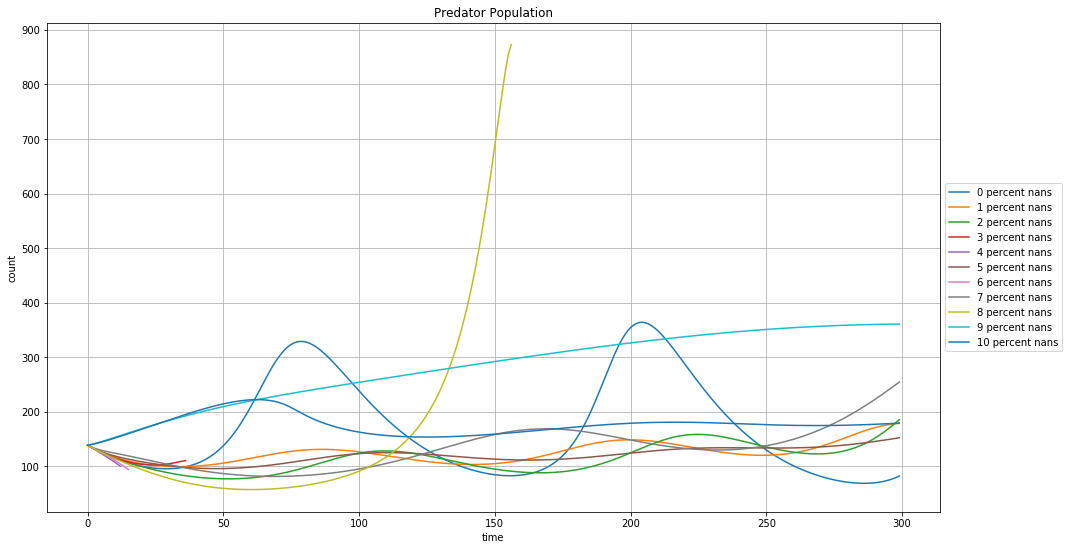

In [19]:
import matplotlib.pyplot as plt

plt.clf()

plt.figure(figsize=(16, 9))
column = 0

title = fields[column]
plt.title(title)
plt.xlabel('time')
plt.ylabel('count')

for nans_percent in preds_data.keys():
    preds_data_part = preds_data[nans_percent]
    plt.plot(preds_data_part[:args['iterations_count'], column], label='{} percent nans'.format(nans_percent))

# plt.plot(y_test[:iterations_count, column], label='y actual')
# plt.plot(prn_valid_y[:iterations_count, column], label='y')
# plt.plot(prn_iterative[:, column], label='prn')
# plt.plot(nn_iterative[:, column], label='nn')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(images_dir, title))

<Figure size 432x288 with 0 Axes>

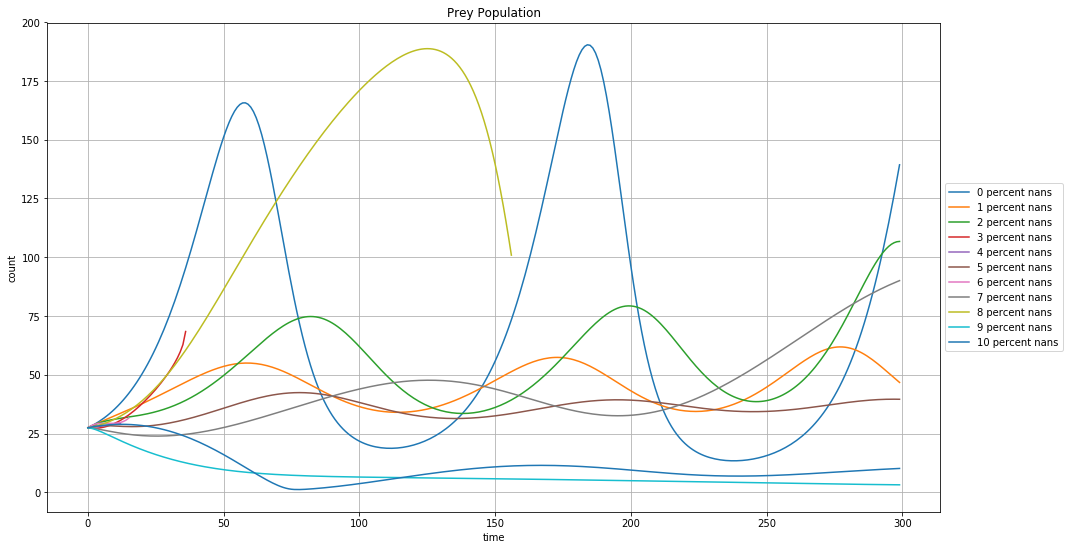

In [18]:
import matplotlib.pyplot as plt

plt.clf()

plt.figure(figsize=(16, 9))
column = 1

title = fields[column]
plt.title(title)
plt.xlabel('time')
plt.ylabel('count')

for nans_percent in preds_data.keys():
    preds_data_part = preds_data[nans_percent]
    plt.plot(preds_data_part[:args['iterations_count'], column], label='{} percent nans'.format(nans_percent))

# plt.plot(y_test[:iterations_count, column], label='y actual')
# plt.plot(prn_valid_y[:iterations_count, column], label='y')
# plt.plot(prn_iterative[:, column], label='prn')
# plt.plot(nn_iterative[:, column], label='nn')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(images_dir, title))